The idea is to create some new imbeddings for the "ground truth" of each object with an added semantic direction. "a photo of a {ground truth} from {direction}".

In [1]:
from clip_pipeline import CLIPModel
import json
import matplotlib.pyplot as plt

import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from math import ceil, sqrt
from matplotlib import gridspec

model = CLIPModel()
with open('Embeddings/Dataset.json', 'r') as f:
    dataset = json.load(f)
with open('Data/Dataset/GT_labels.json', 'r') as f:
    GT_labels = json.load(f)

In [11]:
# semantic direction
direction = [
   # Basic geometric directions
   "front", "back", "left", "right", "side", "top", "bottom",
   
   # Perspective/viewpoint terms
   "above", "below", "overhead", "underneath", "behind", "forward", "backward", "sideways", "profile",
   
   # Angular/rotational
   "diagonal", "angled", "tilted", "rotated", "upright", "inverted", "horizontal", "vertical",
]

# compute semantic embeddings
labels, semantic_labels, semantic = list(), list(), list()
for v in range(len(direction)):
    semantic.append(model.embed(f"{direction[v]}"))

for i,obj in enumerate(dataset["rot"].keys()):
    labels.append(model.embed(f"a photo of a {GT_labels[obj]} from the"))
    semantic_labels.append([])
    for v in range(len(direction)):
        semantic_labels[i].append(model.embed(f"a photo of a {GT_labels[obj]} from the {direction[v]}."))
        

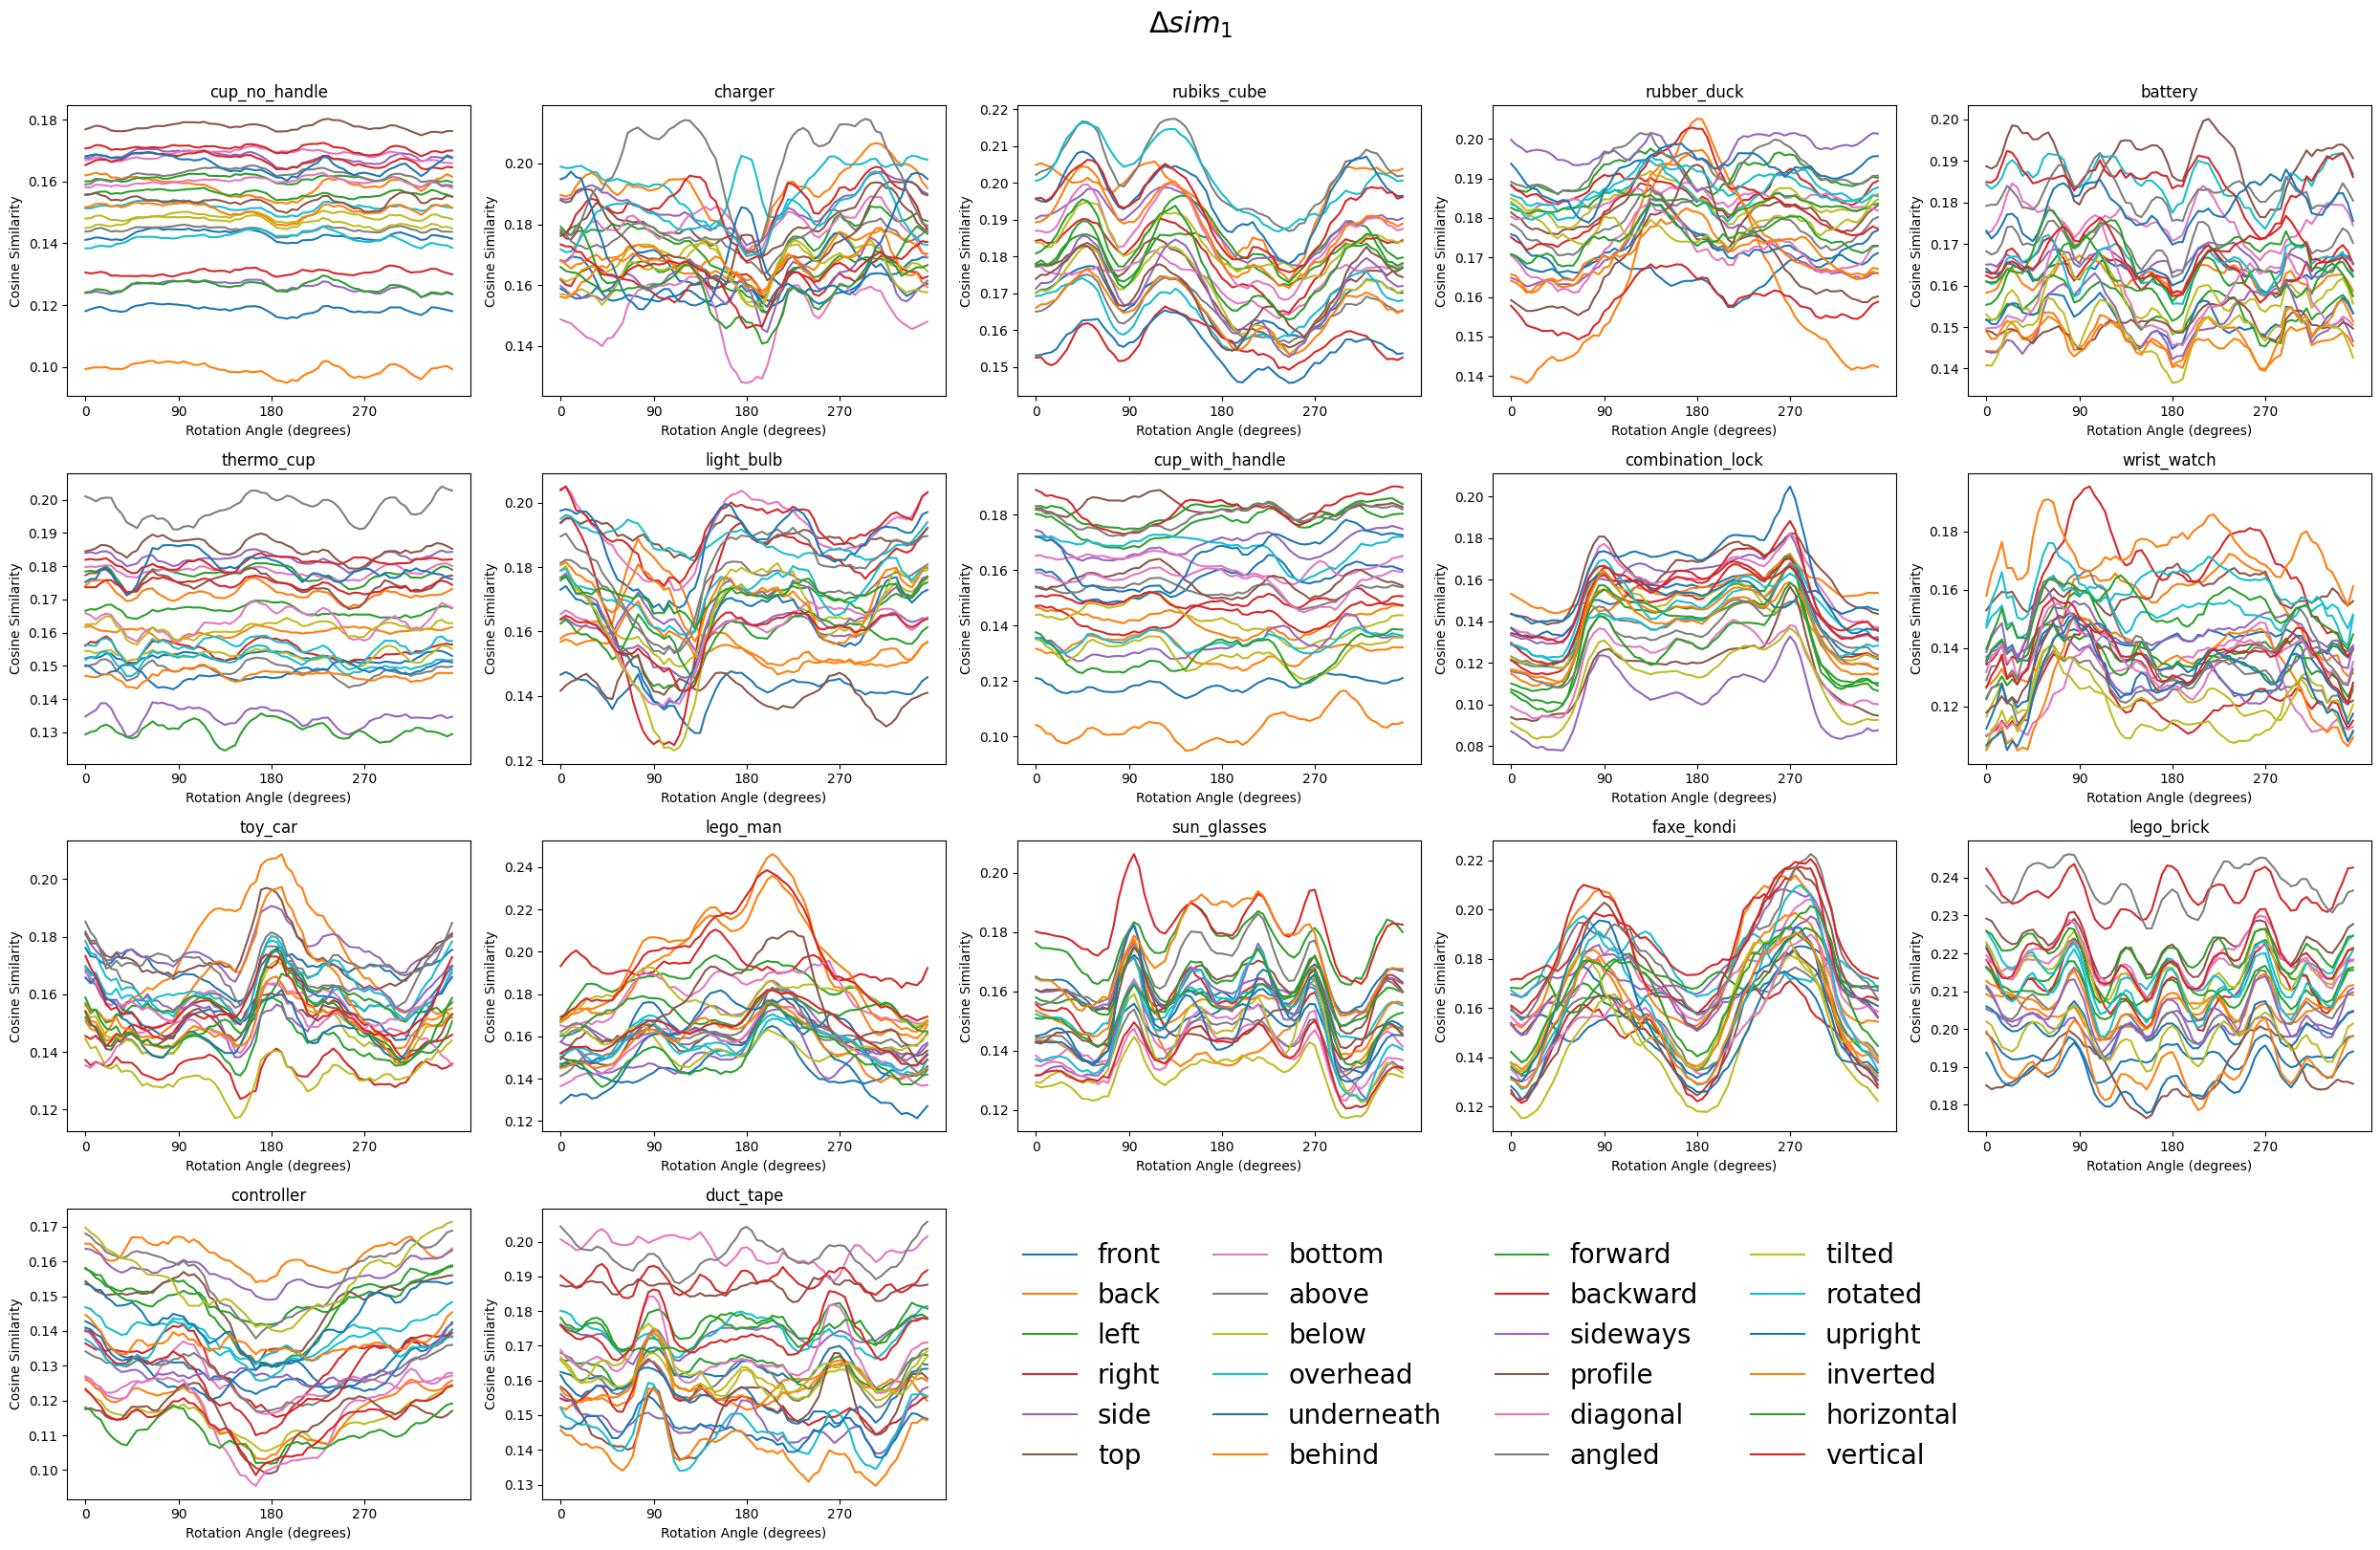

In [13]:
num_objs = len(dataset["rot"].keys())
cols = int(ceil(sqrt(num_objs)))
rows = int(ceil(num_objs / cols))

fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 4), squeeze=False)

total_all_sims = []
for obj_idx, (obj, ax) in enumerate(zip(dataset["rot"].keys(), axes.flat)):
    all_sims = []
    for i in range(72):
        delta1, delta2, delta3 = list(), list(), list()
        for v in range(len(direction)):
            sim_semantic = cosine_similarity(
                np.array(dataset["rot"][obj][f"{i*5}"]).reshape(1, -1),
                np.array(semantic[v]).reshape(1, -1)
            )[0, 0]
            sim_semantic_label = cosine_similarity(
                np.array(dataset["rot"][obj][f"{i*5}"]).reshape(1, -1),
                np.array(semantic_labels[obj_idx][v]).reshape(1, -1)
            )[0, 0]
            sim_label = cosine_similarity(
                np.array(dataset["rot"][obj][f"{i*5}"]).reshape(1, -1),
                np.array(labels[obj_idx]).reshape(1, -1)
            )[0, 0]
            sim_delta = cosine_similarity(
                np.array(dataset["rot"][obj][f"{i*5}"]).reshape(1, -1),
                np.array(semantic_labels[obj_idx][v] - labels[obj_idx]).reshape(1, -1)
            )[0, 0]
            delta1.append(sim_semantic)
            delta2.append(sim_delta)
            delta3.append(sim_semantic_label - sim_label)
        
        all_sims.append([delta1, delta2, delta3])
    total_all_sims.append(all_sims)
    for v in range(len(direction)):
        # just using delta1 for plotting now
        sims = [all_sims[i][0][v] for i in range(72)]
        # Smooth the curve using a moving average with circular (wrap-around) padding
        window = 5
        sims_arr = np.array(sims)
        if len(sims_arr) >= window:
            pad = window // 2
            sims_padded = np.concatenate([sims_arr[-pad:], sims_arr, sims_arr[:pad]])
            sims_smoothed = np.convolve(sims_padded, np.ones(window)/window, mode='valid')
        else:
            sims_smoothed = sims_arr
        ax.plot(range(72), sims_smoothed, label=f'{direction[v]}')
        ax.set_xticks([i*18 for i in range(4)])
        ax.set_xticklabels([f'{i*90}' for i in range(4)])
        ax.set_xlabel('Rotation Angle (degrees)')
        ax.set_ylabel('Cosine Similarity')
        ax.set_title(f'{obj}')

fig.suptitle('$\\Delta sim_1$', fontsize=22, y=1.01)

handles, labels_ = axes[0, 0].get_legend_handles_labels()
fig.legend(handles, labels_,
           ncol=4,
           loc='center left',
           bbox_to_anchor=(0.42, 0.13),
           fontsize=20,
           frameon=False)

for idx in range(num_objs, rows * cols):
    fig.delaxes(axes.flat[idx])

plt.tight_layout()
plt.savefig(f'line_2.pdf', bbox_inches='tight')




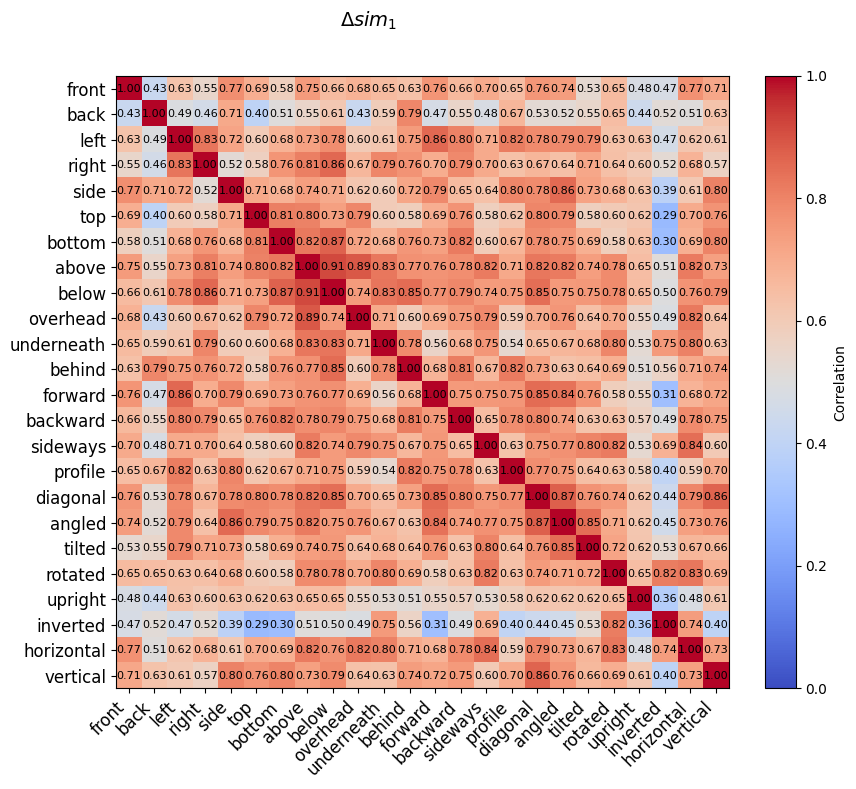

In [18]:

# Convert all_sims to a numpy array for easier manipulation
# Use only delta1 (index 0) for correlation: shape (num_objs*72, len(direction))
all_sims_arr = np.vstack([[all_sims[i][0] for i in range(72)] for all_sims in total_all_sims])

# Compute correlation matrix between the directions
corr_matrix = np.corrcoef(all_sims_arr, rowvar=False)

fig, ax = plt.subplots(figsize=(10, 8))
im = ax.imshow(corr_matrix, vmin=0, vmax=1, cmap='coolwarm')

# Set ticks and labels
ax.set_xticks(np.arange(len(direction)))
ax.set_yticks(np.arange(len(direction)))
ax.set_xticklabels(direction, rotation=45, ha='right', fontsize=12)
ax.set_yticklabels(direction, fontsize=12)

# Annotate correlation values
for i in range(len(direction)):
    for j in range(len(direction)):
        ax.text(j, i, f"{corr_matrix[i, j]:.2f}", ha='center', va='center', color='black', fontsize=8)

fig.suptitle('$\\Delta sim_1$', fontsize=14)
cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04, label='Correlation')
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.savefig(f'corr_2.pdf', bbox_inches='tight')


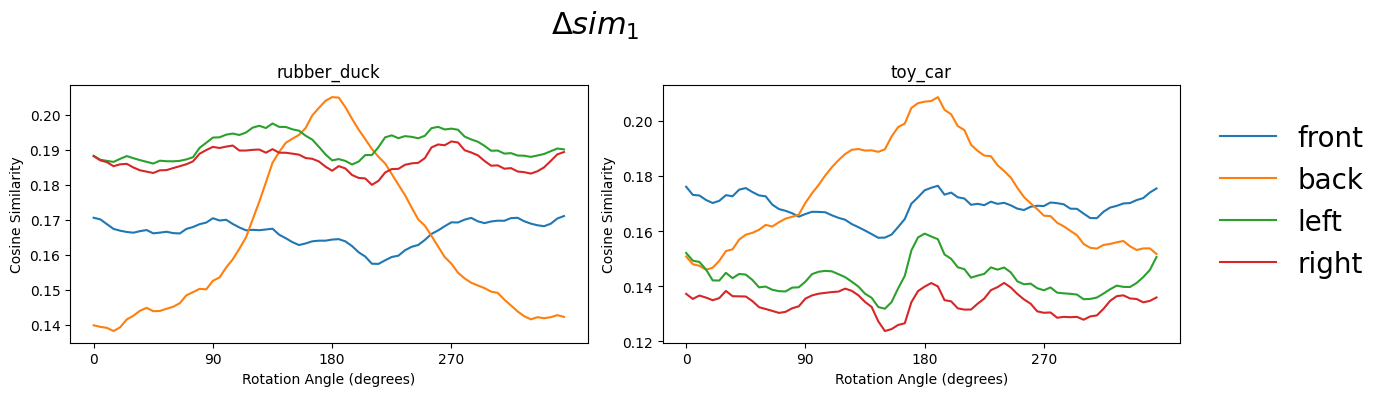

In [164]:
# just gonna make a plot for rubber duck and toy car
fig, axes = plt.subplots(1, 2, figsize=(12, 4), squeeze=False)
obj = ['rubber_duck', 'toy_car']
for u, obj_idx in enumerate([3, 10]):
    ax = axes[0, u]
    for v in range(len(direction)):
        # just using delta1 for plotting now
        sims = [total_all_sims[obj_idx][i][0][v] for i in range(72)]
        # Smooth the curve using a moving average with circular (wrap-around) padding
        window = 5
        sims_arr = np.array(sims)
        if len(sims_arr) >= window:
            pad = window // 2
            sims_padded = np.concatenate([sims_arr[-pad:], sims_arr, sims_arr[:pad]])
            sims_smoothed = np.convolve(sims_padded, np.ones(window)/window, mode='valid')
        else:
            sims_smoothed = sims_arr
        ax.plot(range(72), sims_smoothed, label=f'{direction[v]}')
        ax.set_xticks([i*18 for i in range(4)])
        ax.set_xticklabels([f'{i*90}' for i in range(4)])
        ax.set_xlabel('Rotation Angle (degrees)')
        ax.set_ylabel('Cosine Similarity')
        ax.set_title(f'{obj[u]}')

fig.suptitle('$\\Delta sim_1$', fontsize=22)
handles, labels_ = axes[0, 0].get_legend_handles_labels()
fig.legend(handles, labels_,
           ncol=1,
           loc='center left',
           bbox_to_anchor=(1, 0.5),
           fontsize=20,
           frameon=False)

plt.tight_layout()
plt.savefig('Direction_Comparison.pdf', bbox_inches='tight')

In [4]:
# so this is object0, rotation0, delta1(0), semantic0 
print(total_all_sims[0][0][0][0])

# so this is object1, rotation15(4), delta2(1), semantic[:]
print(total_all_sims[1][4][1][:])

0.1395365001241715
[np.float64(0.05386594769966087), np.float64(0.02655803673406694), np.float64(0.006853161196542733), np.float64(0.010939044455916175)]


/tmp/ipykernel_23291/2697525235.py:44: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.97])


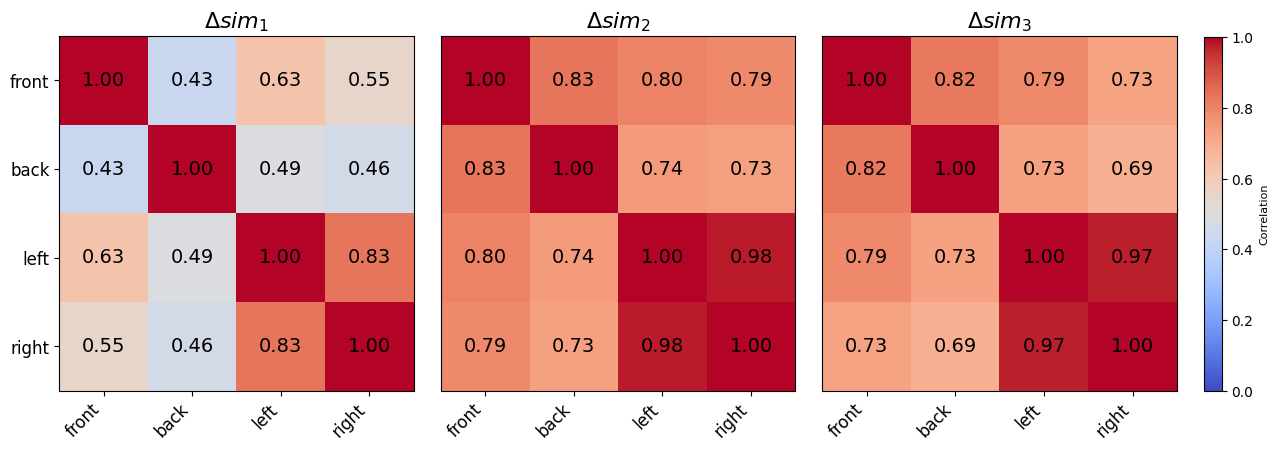

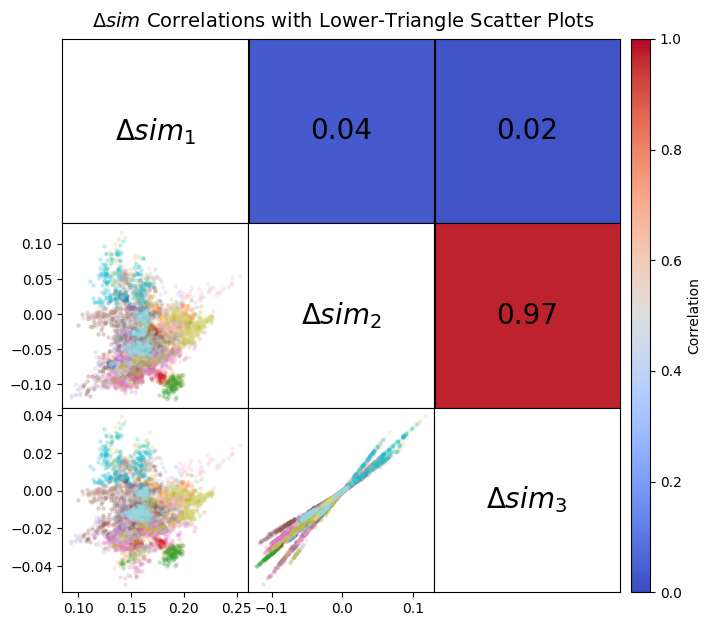

In [8]:
# Convert all_sims to a numpy array for easier manipulation
delta1 = np.array([[all_sims[i][0] for i in range(72)] for all_sims in total_all_sims])
delta2 = np.array([[all_sims[i][1] for i in range(72)] for all_sims in total_all_sims])
delta3 = np.array([[all_sims[i][2] for i in range(72)] for all_sims in total_all_sims])

# Flatten the 3 deltas to shape (num_objs * 72, len(direction))
delta1_flat = delta1.reshape(-1, len(direction))
delta2_flat = delta2.reshape(-1, len(direction))
delta3_flat = delta3.reshape(-1, len(direction))
# Compute correlation matrices for each delta
corr_matrix_delta1 = np.corrcoef(delta1_flat, rowvar=False)
corr_matrix_delta2 = np.corrcoef(delta2_flat, rowvar=False)
corr_matrix_delta3 = np.corrcoef(delta3_flat, rowvar=False)

fig = plt.figure(figsize=(15, 5))  # adjust size as needed
gs = gridspec.GridSpec(1, 4, width_ratios=[1, 1, 1, 0.05], wspace=0.1)  # 3 plots + 1 thin column for colorbar

axs = [fig.add_subplot(gs[i]) for i in range(3)]  # 3 axes

for idx, (corr_matrix, title) in enumerate(zip(
    [corr_matrix_delta1, corr_matrix_delta2, corr_matrix_delta3],
    ['$\\Delta sim_1$', '$\\Delta sim_2$', '$\\Delta sim_3$']
)):
    im = axs[idx].imshow(corr_matrix, vmin=0, vmax=1, cmap='coolwarm')
    axs[idx].set_xticks(np.arange(len(direction)))
    axs[idx].set_yticks(np.arange(len(direction)))
    axs[idx].set_xticklabels(direction, rotation=45, ha='right', fontsize=12)
    axs[idx].set_yticklabels(direction, fontsize=12)
    axs[idx].set_title(title, fontsize=16)

    for i in range(len(direction)):
        for j in range(len(direction)):
            axs[idx].text(j, i, f"{corr_matrix[i, j]:.2f}", ha='center', va='center', color='black', fontsize=14)

cbar_ax = fig.add_subplot(gs[3])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label('Correlation', fontsize=8)
pos = cbar_ax.get_position()
cbar_ax.set_position([pos.x0, pos.y0+0.03, pos.width, pos.height-0.063])
for ax in axs[1:3]:
    ax.set_yticks([])
    ax.set_yticklabels([])
    ax.set_ylabel('')
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.savefig('Semantic_Correlations_Heatmaps.pdf', bbox_inches='tight', dpi=300)



deltas_stack = np.stack([delta1_flat, delta2_flat, delta3_flat], axis=2)  # shape: (num_samples, len(direction), 3)
# Reshape to (num_samples * len(direction), 3)
deltas_stack_flat = deltas_stack.reshape(-1, 3)

labels = ['$\\Delta sim_1$', '$\\Delta sim_2$', '$\\Delta sim_3$']
num_vars = 3

# Extract columns from flattened delta stack
d1, d2, d3 = deltas_stack_flat[:, 0], deltas_stack_flat[:, 1], deltas_stack_flat[:, 2]
deltas = [d1, d2, d3]

# Recompute correlation to annotate correctly
corr = np.corrcoef(deltas_stack_flat, rowvar=False)

fig = plt.figure(figsize=(6, 6))
gs = gridspec.GridSpec(num_vars, num_vars, wspace=0.0, hspace=0.0)

colors = plt.cm.tab20(np.linspace(0, 1, deltas_stack.shape[0]))  # one color per object (num_objs * 72)
obj_ids = np.repeat(np.arange(deltas_stack.shape[0]), len(direction))  # shape: (num_objs * 72,)

for i in range(num_vars):
    for j in range(num_vars):
        ax = fig.add_subplot(gs[i, j])
        
        if i == j:
            ax.text(0.5, 0.5, labels[i], ha='center', va='center', fontsize=20)
            ax.set_xticks([])
            ax.set_yticks([])

        elif i < j:
            # Upper triangle: correlation heatmap cell with value
            im = ax.imshow([[corr[i, j]]], vmin=0, vmax=1, cmap='coolwarm')
            ax.set_xticks([])
            ax.set_yticks([])
            ax.text(0.0, 0.0, f"{corr[i, j]:.2f}", ha='center', va='center', color='black', fontsize=20)

        else:
            # Lower triangle: scatter plot, color by object
            for obj_idx in range(deltas_stack.shape[0]):
                idxs = np.where(obj_ids == obj_idx)[0]
                ax.scatter(deltas[j][idxs], deltas[i][idxs], color=colors[obj_idx], alpha=0.2, s=5)
            if j == 0:
                ax.set_ylabel('', fontsize=12)
            else:
                ax.set_yticks([])

            if i == num_vars - 1:
                ax.set_xlabel('', fontsize=12)
            else:
                ax.set_xticks([])

plt.suptitle("$\\Delta sim$ Correlations with Lower-Triangle Scatter Plots", x=0.555, y=1.01, fontsize=14)
plt.tight_layout(rect=[0, 0, 1.07, 1], pad=0)

fig.colorbar(im, ax=fig.axes, fraction=0.035, pad=0.02, aspect=30, label='Correlation')
plt.savefig('Delta_Correlations.pdf', bbox_inches='tight', dpi=300)


/tmp/ipykernel_23291/3997471323.py:135: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.97])


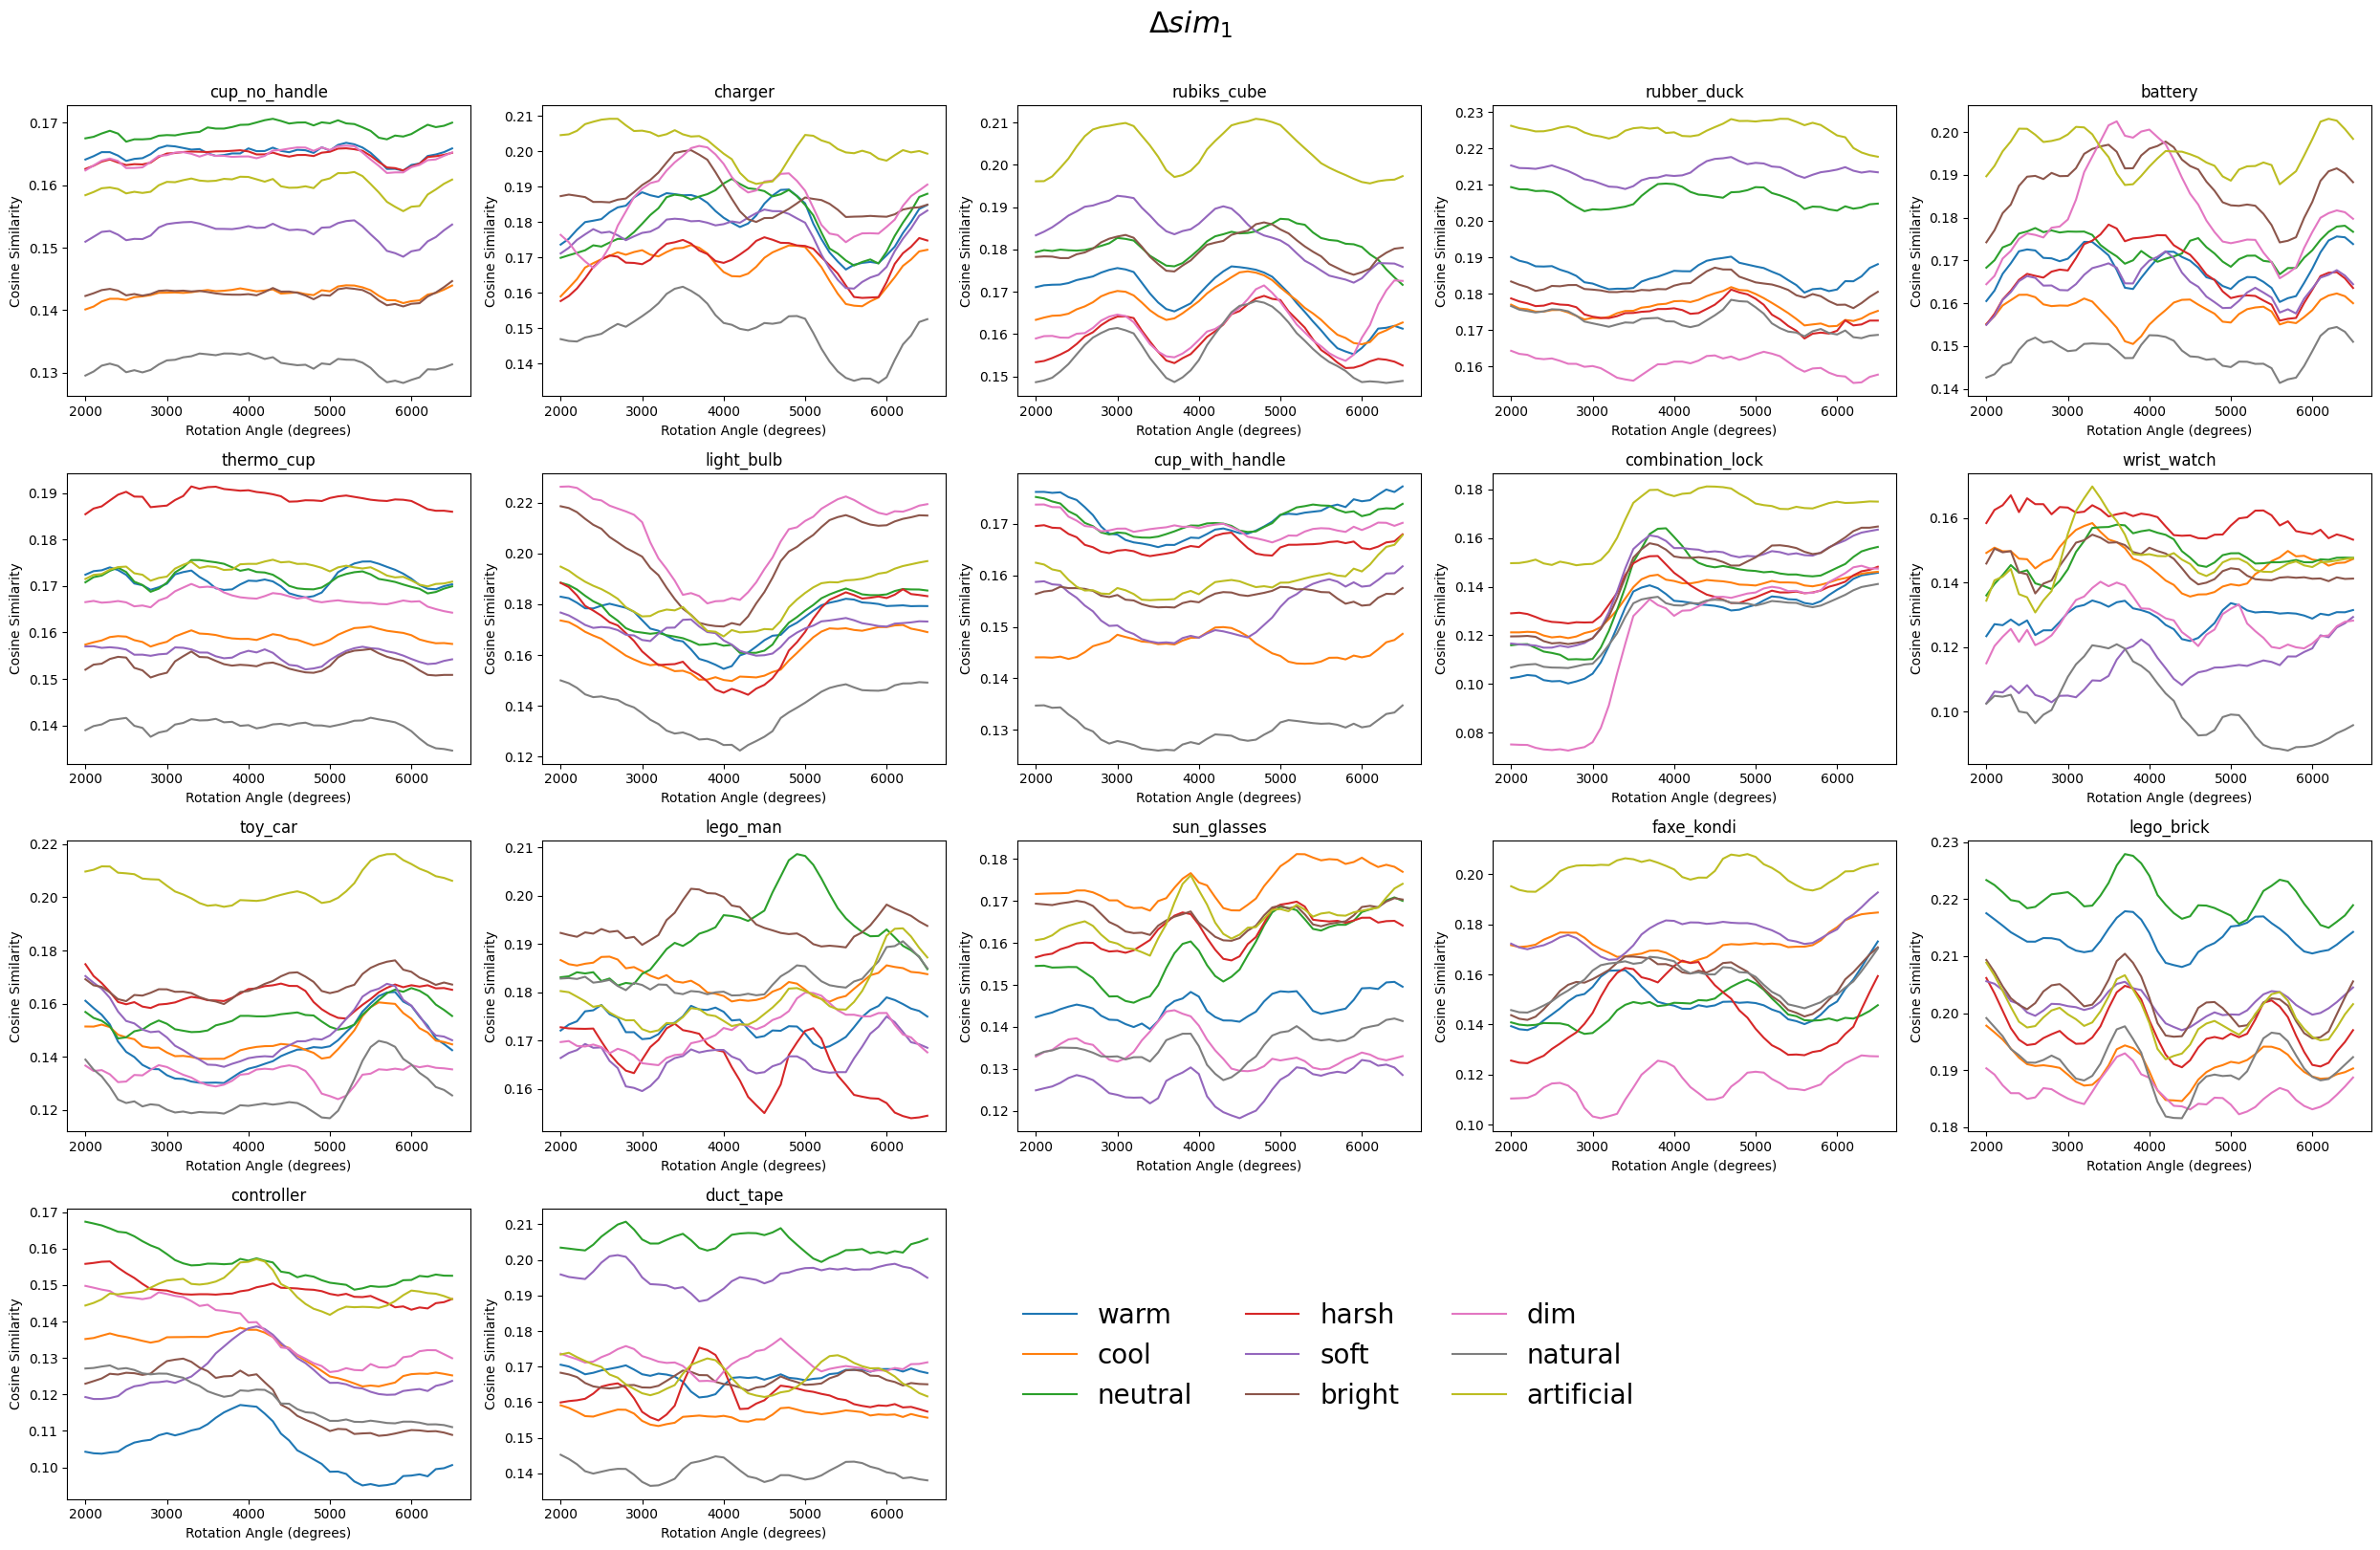

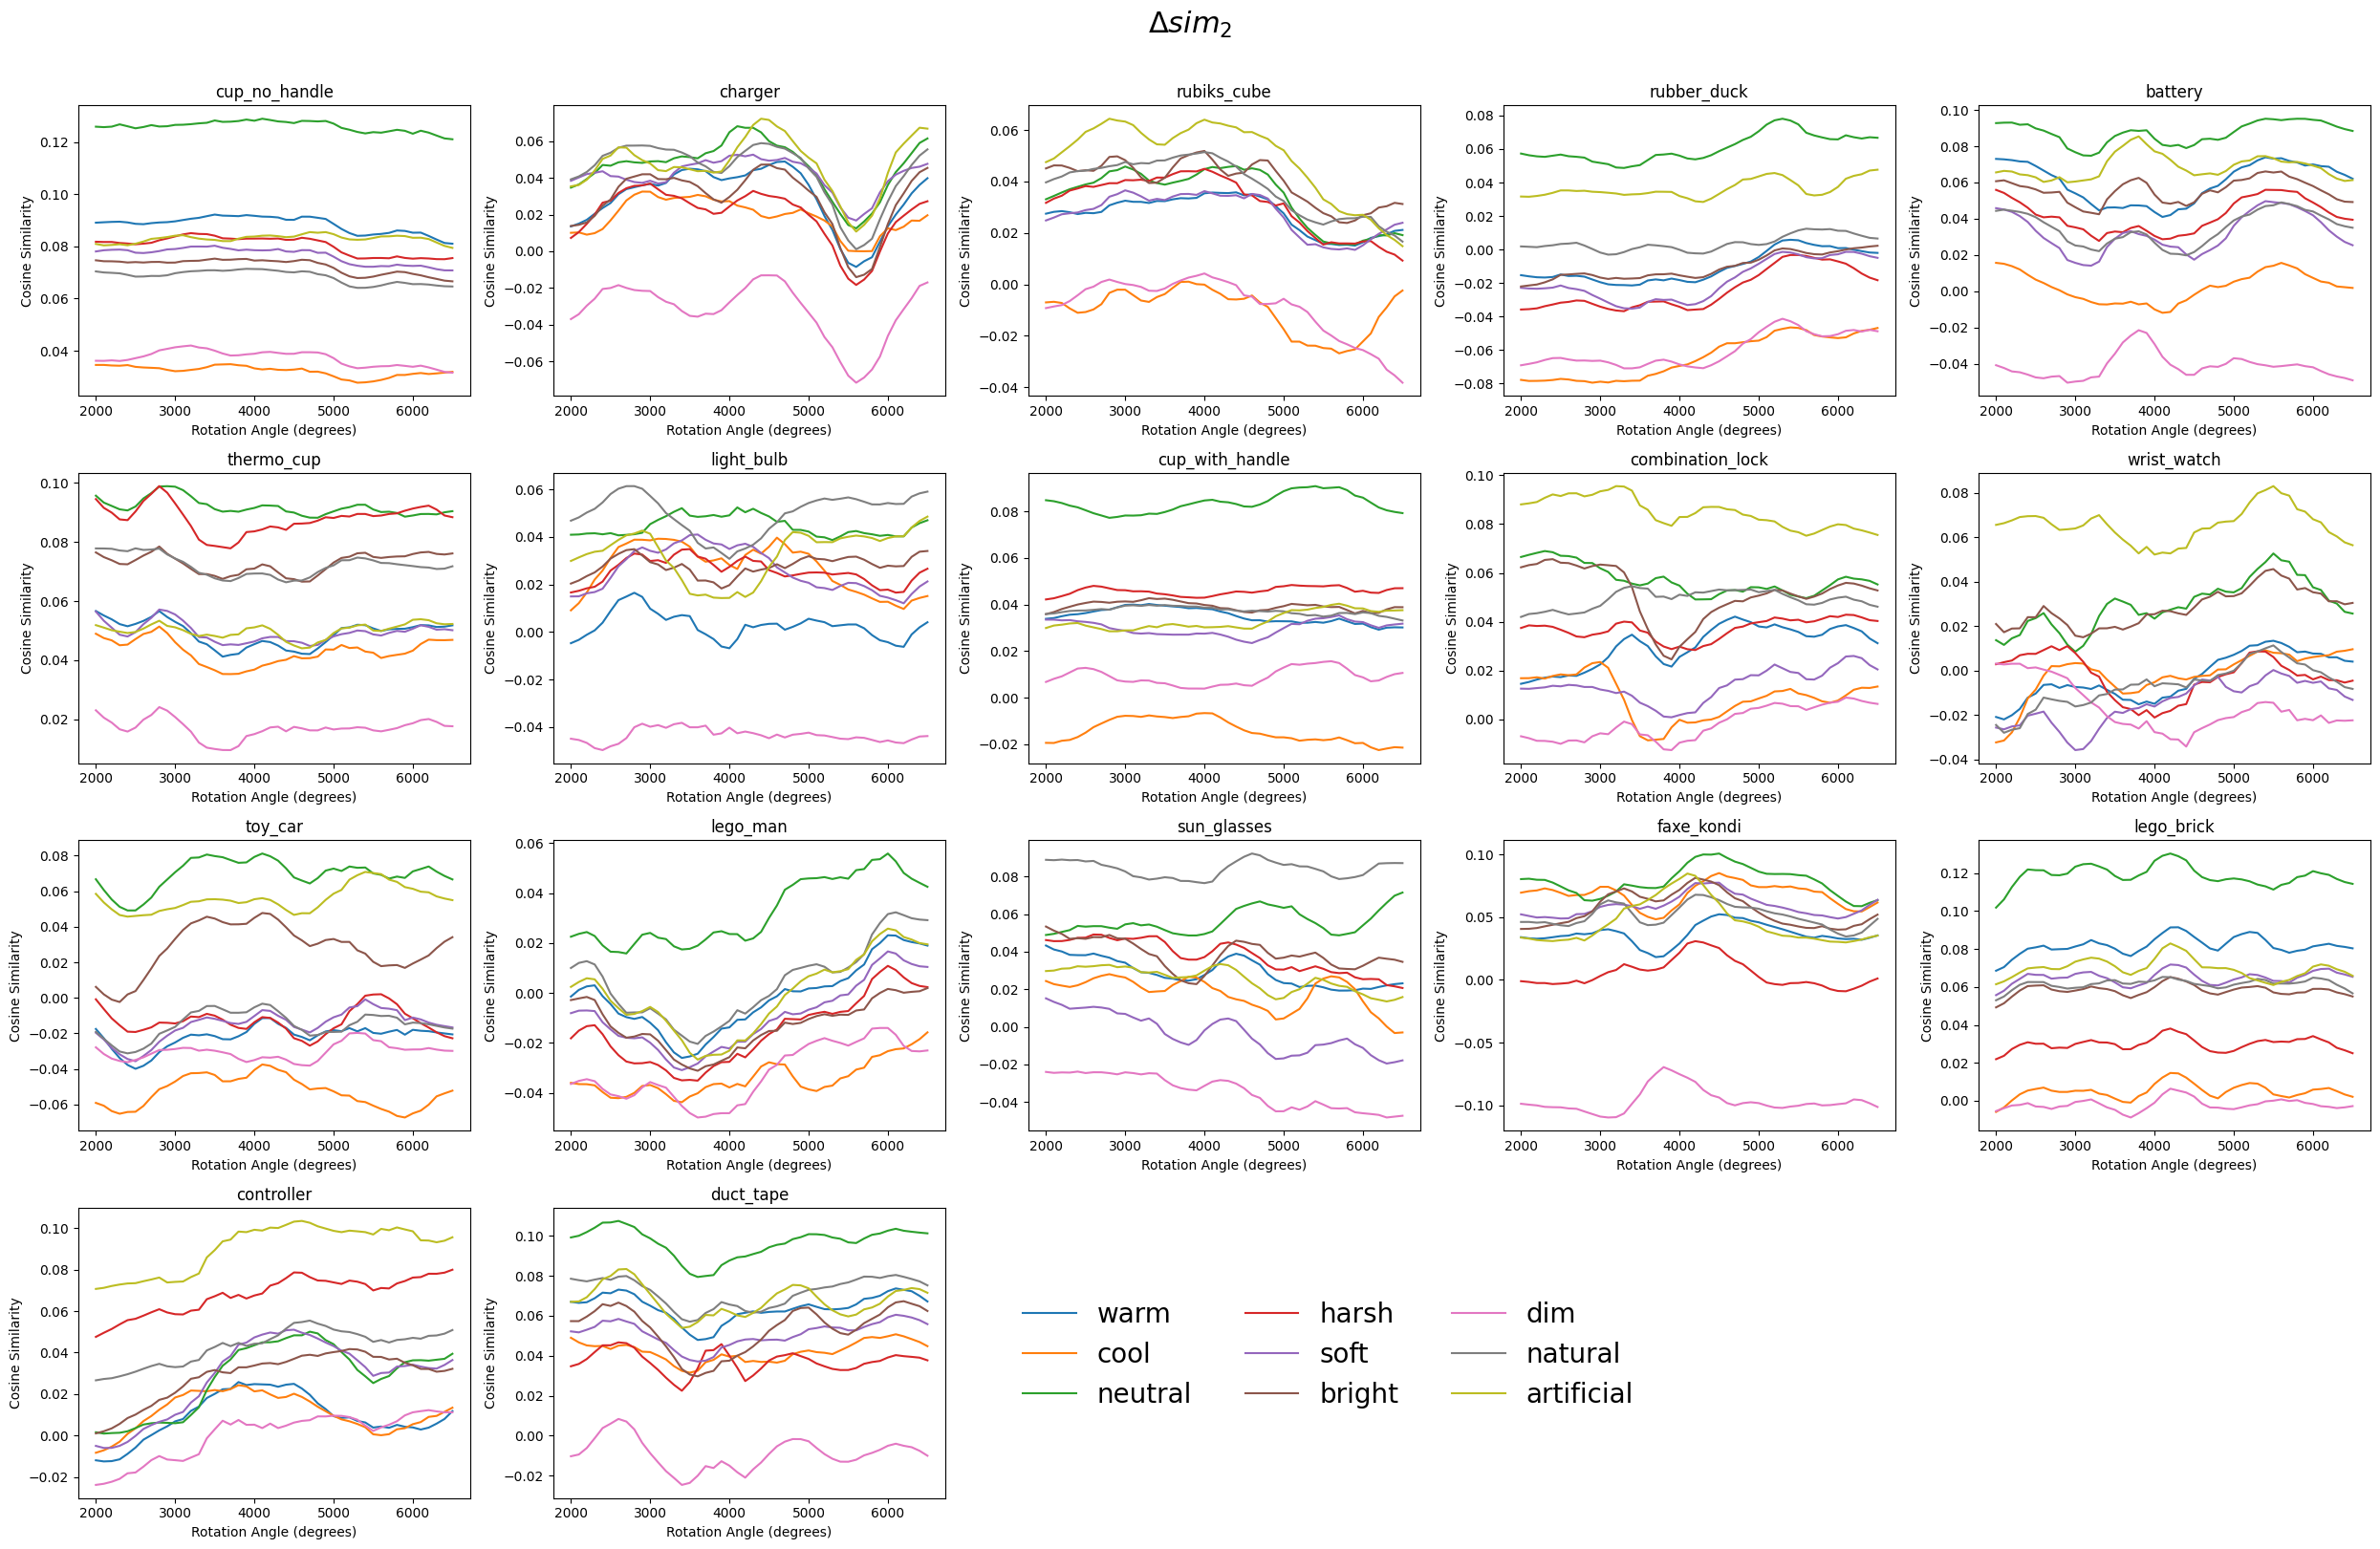

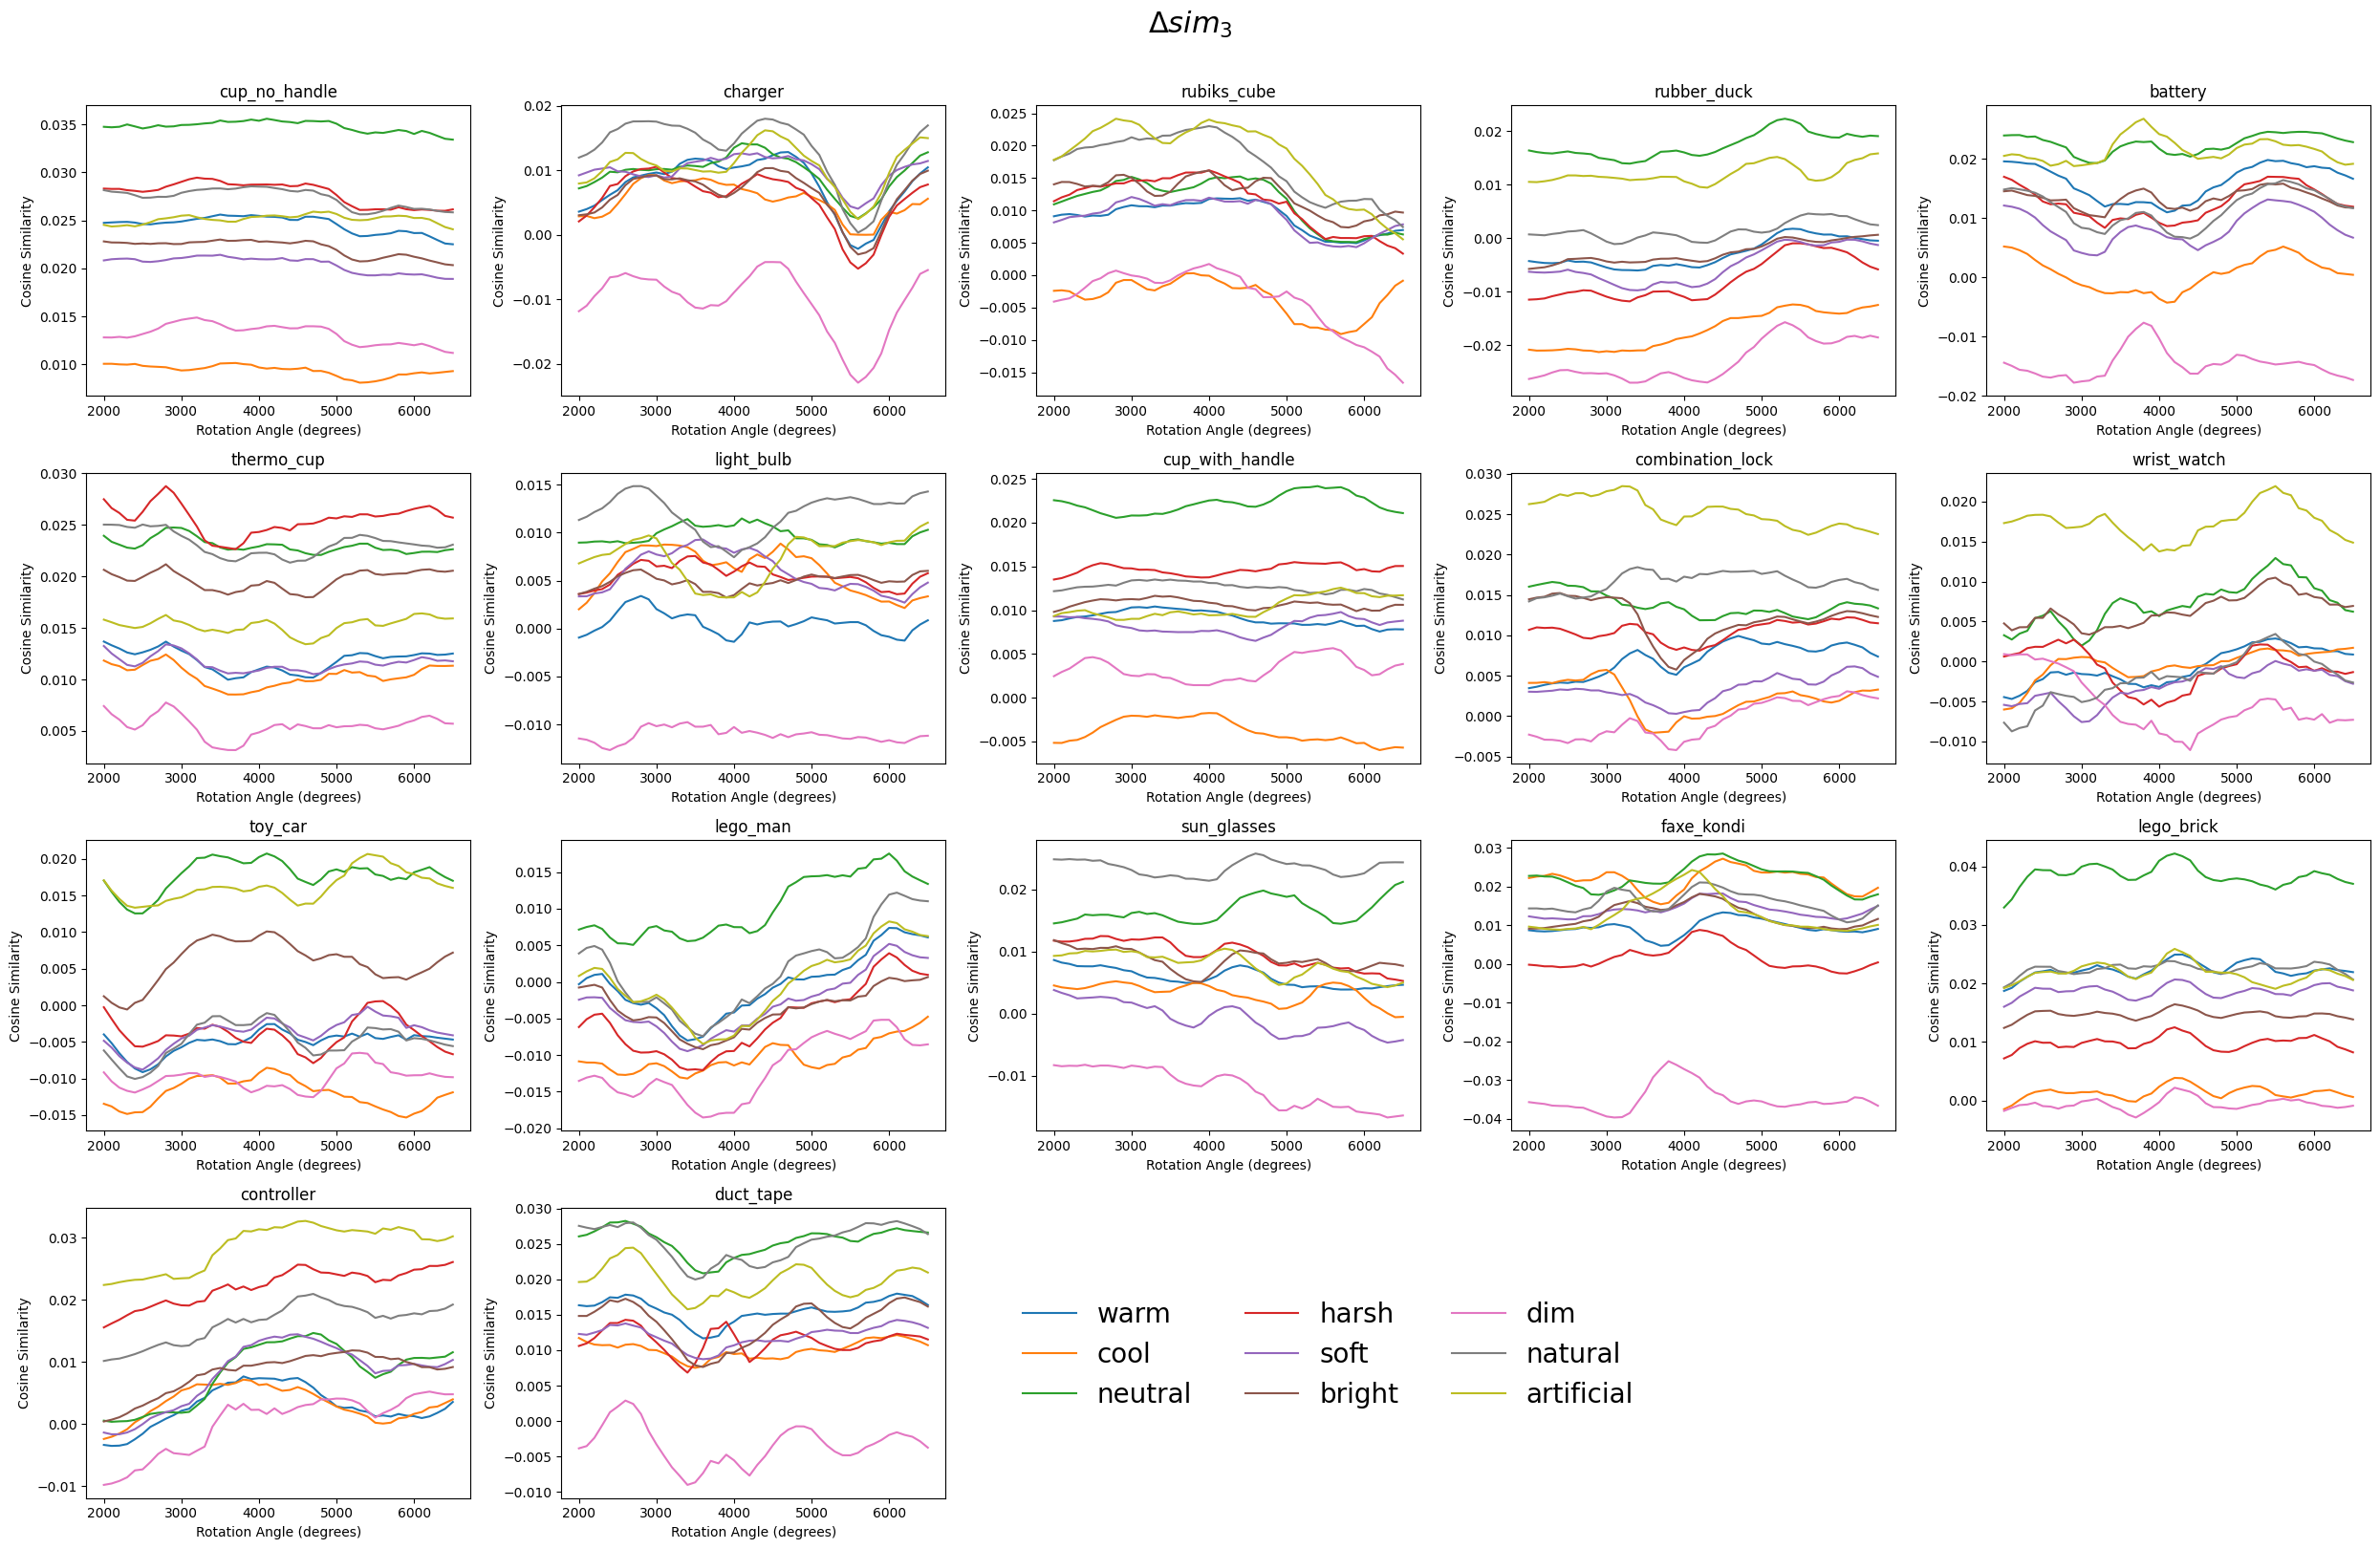

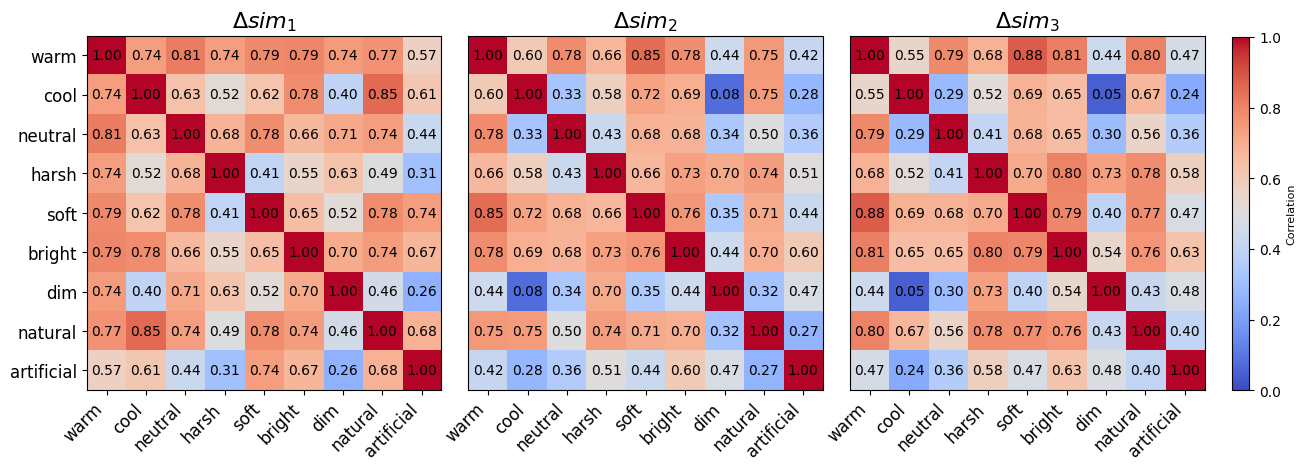

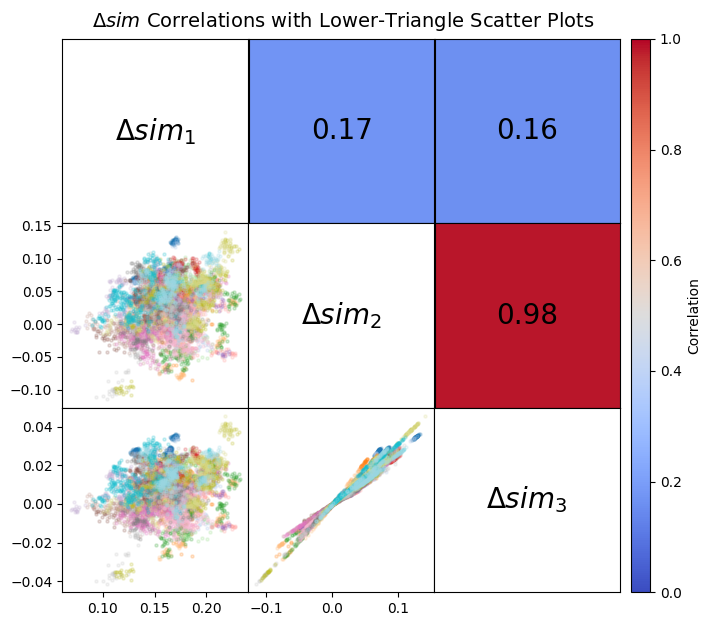

In [20]:
# semantic "direction" (temperature) instead of changing the code
direction = ["warm", "cool", "neutral", "harsh", "soft", "bright", "dim", "natural", "artificial"]

# compute semantic embeddings
labels, semantic_labels, semantic = list(), list(), list()
for v in range(len(direction)):
    semantic.append(model.embed(f"{direction[v]}"))
for i,obj in enumerate(dataset["temp"].keys()):
    labels.append(model.embed(f"a photo of a {GT_labels[obj]} in lighting."))
    semantic_labels.append([])
    for v in range(len(direction)):
        semantic_labels[i].append(model.embed(f"a photo of a {GT_labels[obj]} in {direction[v]} lighting."))

num_objs = len(dataset["temp"].keys())
cols = int(ceil(sqrt(num_objs)))
rows = int(ceil(num_objs / cols))

total_all_sims = []
for obj_idx, obj in enumerate(dataset["temp"].keys()):
    all_sims = []
    for i in range(46):
        delta1, delta2, delta3 = list(), list(), list()
        for v in range(len(direction)):
            sim_semantic = cosine_similarity(
                np.array(dataset["rot"][obj][f"{i*5}"]).reshape(1, -1),
                np.array(semantic[v]).reshape(1, -1)
            )[0, 0]
            sim_semantic_label = cosine_similarity(
                np.array(dataset["rot"][obj][f"{i*5}"]).reshape(1, -1),
                np.array(semantic_labels[obj_idx][v]).reshape(1, -1)
            )[0, 0]
            sim_label = cosine_similarity(
                np.array(dataset["rot"][obj][f"{i*5}"]).reshape(1, -1),
                np.array(labels[obj_idx]).reshape(1, -1)
            )[0, 0]
            sim_delta = cosine_similarity(
                np.array(dataset["rot"][obj][f"{i*5}"]).reshape(1, -1),
                np.array(semantic_labels[obj_idx][v] - labels[obj_idx]).reshape(1, -1)
            )[0, 0]
            delta1.append(sim_semantic)
            delta2.append(sim_delta)
            delta3.append(sim_semantic_label - sim_label)
        
        all_sims.append([delta1, delta2, delta3])
    total_all_sims.append(all_sims)



titles = ["$\\Delta sim_1$", "$\\Delta sim_2$", "$\\Delta sim_3$"]
for d in range(3):
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 4), squeeze=False)
    for obj_idx, (obj, ax) in enumerate(zip(dataset["temp"].keys(), axes.flat)):
        for v in range(len(direction)):
            
            sims = [total_all_sims[obj_idx][i][d][v] for i in range(46)]
            # Smooth the curve using a moving average with circular (wrap-around) padding
            window = 5
            sims_arr = np.array(sims)
            if len(sims_arr) >= window:
                pad = window // 2
                # Pad with edge values instead of wrapping
                sims_padded = np.pad(sims_arr, (pad, pad), mode='edge')
                sims_smoothed = np.convolve(sims_padded, np.ones(window)/window, mode='valid')
            else:
                sims_smoothed = sims_arr
            ax.plot(range(46), sims_smoothed, label=f'{direction[v]}')
            ax.set_xticks([i*10 for i in range(5)])
            ax.set_xticklabels([f'{2000 + i*1000}' for i in range(5)])
            ax.set_xlabel('Rotation Angle (degrees)')
            ax.set_ylabel('Cosine Similarity')
            ax.set_title(f'{obj}')

    fig.suptitle(titles[d], fontsize=22, y=1.01)

    handles, labels_ = axes[0, 0].get_legend_handles_labels()
    fig.legend(handles, labels_,
            ncol=3,
            loc='center left',
            bbox_to_anchor=(0.42, 0.13),
            fontsize=20,
            frameon=False)

    for idx in range(num_objs, rows * cols):
        fig.delaxes(axes.flat[idx])

    plt.tight_layout()
    plt.savefig(f'line_{d+1}.pdf', bbox_inches='tight')




# Convert all_sims to a numpy array for easier manipulation
delta1 = np.array([[all_sims[i][0] for i in range(46)] for all_sims in total_all_sims])
delta2 = np.array([[all_sims[i][1] for i in range(46)] for all_sims in total_all_sims])
delta3 = np.array([[all_sims[i][2] for i in range(46)] for all_sims in total_all_sims])

# Flatten the 3 deltas to shape (num_objs * 72, len(direction))
delta1_flat = delta1.reshape(-1, len(direction))
delta2_flat = delta2.reshape(-1, len(direction))
delta3_flat = delta3.reshape(-1, len(direction))
# Compute correlation matrices for each delta
corr_matrix_delta1 = np.corrcoef(delta1_flat, rowvar=False)
corr_matrix_delta2 = np.corrcoef(delta2_flat, rowvar=False)
corr_matrix_delta3 = np.corrcoef(delta3_flat, rowvar=False)

fig = plt.figure(figsize=(15, 5))  # adjust size as needed
gs = gridspec.GridSpec(1, 4, width_ratios=[1, 1, 1, 0.05], wspace=0.1)  # 3 plots + 1 thin column for colorbar

axs = [fig.add_subplot(gs[i]) for i in range(3)]  # 3 axes

for idx, (corr_matrix, title) in enumerate(zip(
    [corr_matrix_delta1, corr_matrix_delta2, corr_matrix_delta3],
    ['$\\Delta sim_1$', '$\\Delta sim_2$', '$\\Delta sim_3$']
)):
    im = axs[idx].imshow(corr_matrix, vmin=0, vmax=1, cmap='coolwarm')
    axs[idx].set_xticks(np.arange(len(direction)))
    axs[idx].set_yticks(np.arange(len(direction)))
    axs[idx].set_xticklabels(direction, rotation=45, ha='right', fontsize=12)
    axs[idx].set_yticklabels(direction, fontsize=12)
    axs[idx].set_title(title, fontsize=16)

    for i in range(len(direction)):
        for j in range(len(direction)):
            axs[idx].text(j, i, f"{corr_matrix[i, j]:.2f}", ha='center', va='center', color='black', fontsize=10)

cbar_ax = fig.add_subplot(gs[3])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label('Correlation', fontsize=8)
pos = cbar_ax.get_position()
cbar_ax.set_position([pos.x0, pos.y0+0.03, pos.width, pos.height-0.063])
for ax in axs[1:3]:
    ax.set_yticks([])
    ax.set_yticklabels([])
    ax.set_ylabel('')
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.savefig('Semantic_Correlations_Heatmaps_temp.pdf', bbox_inches='tight', dpi=300)



deltas_stack = np.stack([delta1_flat, delta2_flat, delta3_flat], axis=2)  # shape: (num_samples, len(direction), 3)
# Reshape to (num_samples * len(direction), 3)
deltas_stack_flat = deltas_stack.reshape(-1, 3)

labels = ['$\\Delta sim_1$', '$\\Delta sim_2$', '$\\Delta sim_3$']
num_vars = 3

# Extract columns from flattened delta stack
d1, d2, d3 = deltas_stack_flat[:, 0], deltas_stack_flat[:, 1], deltas_stack_flat[:, 2]
deltas = [d1, d2, d3]

# Recompute correlation to annotate correctly
corr = np.corrcoef(deltas_stack_flat, rowvar=False)

fig = plt.figure(figsize=(6, 6))
gs = gridspec.GridSpec(num_vars, num_vars, wspace=0.0, hspace=0.0)

colors = plt.cm.tab20(np.linspace(0, 1, deltas_stack.shape[0]))  # one color per object (num_objs * 72)
obj_ids = np.repeat(np.arange(deltas_stack.shape[0]), len(direction))  # shape: (num_objs * 72,)

for i in range(num_vars):
    for j in range(num_vars):
        ax = fig.add_subplot(gs[i, j])
        
        if i == j:
            ax.text(0.5, 0.5, labels[i], ha='center', va='center', fontsize=20)
            ax.set_xticks([])
            ax.set_yticks([])

        elif i < j:
            # Upper triangle: correlation heatmap cell with value
            im = ax.imshow([[corr[i, j]]], vmin=0, vmax=1, cmap='coolwarm')
            ax.set_xticks([])
            ax.set_yticks([])
            ax.text(0.0, 0.0, f"{corr[i, j]:.2f}", ha='center', va='center', color='black', fontsize=20)

        else:
            # Lower triangle: scatter plot, color by object
            for obj_idx in range(deltas_stack.shape[0]):
                idxs = np.where(obj_ids == obj_idx)[0]
                ax.scatter(deltas[j][idxs], deltas[i][idxs], color=colors[obj_idx], alpha=0.2, s=5)
            if j == 0:
                ax.set_ylabel('', fontsize=12)
            else:
                ax.set_yticks([])

            if i == num_vars - 1:
                ax.set_xlabel('', fontsize=12)
            else:
                ax.set_xticks([])

plt.suptitle("$\\Delta sim$ Correlations with Lower-Triangle Scatter Plots", x=0.555, y=1.01, fontsize=14)
plt.tight_layout(rect=[0, 0, 1.07, 1], pad=0)

fig.colorbar(im, ax=fig.axes, fraction=0.035, pad=0.02, aspect=30, label='Correlation')
plt.savefig('Delta_Correlations_temp.pdf', bbox_inches='tight', dpi=300)
